# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
#import sys
import time
import logging
from scipy.stats import linregress

# Import API key
from api_keys import weather_api_key

# Incorporated citipy to determine nearest city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

# Setup Logging
FORMAT="%(asctime)-15s %(levelname)s:  %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

## Generate Cities List

In [2]:
# This list of cities is randomly distributed by latitude and longitude
# To generate:
#     Generate a list of random locations, by latitude and longitude
#     Find the city nearest each random location
# Since it is possible for random locations to be nearest the same city,
# especially in the oceanic and polar regions, generate a large number
# of random locations; large enough to generate 500+ random cities.
SAMPLE_SIZE = 1500

# Create a set of random lat and lng combinations
lats = np.random.uniform(low=-90.000, high=90.000, size=SAMPLE_SIZE)
lngs = np.random.uniform(low=-180.000, high=180.000, size=SAMPLE_SIZE)

# Allocate space for the city and country names of the random cities (faster than append)
city_names = [None]*SAMPLE_SIZE
country_codes = [None]*SAMPLE_SIZE

# Identify nearest city for each lat, lng combination
for iRow in range(SAMPLE_SIZE):
    #print(iRow)
    city = citipy.nearest_city(lats[iRow], lngs[iRow])
    city_names[iRow] = city.city_name
    country_codes[iRow] = city.country_code

# Create a DataFrame of the random locations, and drop duplicates
random_cities = pd.DataFrame({"city_name" : city_names, "country_code" : country_codes}).drop_duplicates(ignore_index=True)

In [3]:
# For efficiency, use the Open Weather Group API

# The Group API requires location IDs.  
# At http://bulk.openweathermap.org/sample/, Open Weather provides a JSON list of cities and IDs
# Read the city list into a DataFrame
ow_cities = pd.read_json('city.list.json')[["id", "name", "country"]]

# The citipy module provided lowercase city and country names.  Change this DataFrame to match.
ow_cities["name"] = ow_cities["name"].str.lower()
ow_cities["country"] = ow_cities["country"].str.lower()

temp = random_cities.merge(ow_cities, left_on=("city_name","country_code"), right_on=("name","country"))
cities_with_id = pd.pivot_table(temp, values="id", index=['name', 'country'], aggfunc="min").reset_index()
cities_with_id

,name,country,id
0,acarau,br,3408368
1,adrar,dz,2508813
2,ahipara,nz,2194098
3,aklavik,ca,5882953
4,aksarka,ru,1512019
...,...,...,...
500,zeya,ru,2012593
501,zhangjiakou,cn,2033196
502,zhangye,cn,1785036
503,zhigansk,ru,2012530


In [4]:
# It will take 3-4 seconds to retrieve the weather data for 500+ cities
# The Group API handles up to twenty city IDs simultaneously
MAX_GROUP_SIZE = 20

city_ids = cities_with_id["id"].astype(str)

result_list = list()
for range_start in range(0,city_ids.size,20):
    range_end = range_start + min(MAX_GROUP_SIZE, city_ids.size - range_start)
    ids = ",".join(city_ids[range_start:range_end])
    log_message = f"About to request the current weather for these {range_end - range_start} cities:  \n"
    log_message += str(cities_with_id[range_start:range_end])
    logging.info(log_message)
    url = f"http://api.openweathermap.org/data/2.5/group?id={ids}&units=imperial&appid={weather_api_key}"
    result_list += requests.get(url).json()['list']   


2020-03-10 19:33:44,935 INFO:  About to request the current weather for these 20 cities:  
           name country       id
0        acarau      br  3408368
1         adrar      dz  2508813
2       ahipara      nz  2194098
3       aklavik      ca  5882953
4       aksarka      ru  1512019
5     alakurtti      ru   583472
6        albany      au  2077963
7   albertville      fr  3038266
8         alofi      nu  4036284
9       aloleng      ph  1731298
10        altay      cn  1529651
11       alugan      ph  1731248
12        ambon      id  1651531
13       anadyr      ru  2127202
14        ancud      cl  3899695
15       anloga      gh  2304548
16  antofagasta      cl  3899539
17     anuchino      ru  2027596
18       aranos      na  3358666
19     araouane      ml  2460954
2020-03-10 19:33:45,154 INFO:  About to request the current weather for these 20 cities:  
               name country       id
20       arenapolis      br  3471551
21            arlit      ne  2447513
22  arraial do

2020-03-10 19:33:46,470 INFO:  About to request the current weather for these 20 cities:  
             name country       id
200         korla      cn  1529376
201        kozhva      ru   543246
202  kruisfontein      za   986717
203       kumluca      tr   305681
204        kupino      ru  1501365
205       kurchum      kz  1521762
206       kurilsk      ru  2123979
207       kushima      jp  1895695
208   la macarena      co  3827693
209      la ronge      ca  6050066
210      la tuque      ca  6050416
211        labuan      my  1734240
212       lafiagi      ng  2332504
213         lagoa      pt  2267253
214        laguna      br  3459094
215       lahaina      us  5849996
216     lake city      us  4117869
217       lanzhou      cn  1804430
218    lavrentiya      ru  4031637
219          lebu      cl  3883457
2020-03-10 19:33:46,589 INFO:  About to request the current weather for these 20 cities:  
                      name country       id
220          leningradskiy      ru  212

2020-03-10 19:33:49,157 INFO:  About to request the current weather for these 20 cities:  
               name country       id
400           semey      kz  1519422
401        semporna      my  1733697
402       sept-iles      ca  6144312
403  severo-kurilsk      ru  2121385
404        shagonar      ru  1492499
405            shar      kz  1519275
406       shelburne      ca  6145887
407         shimoda      jp  1852357
408        shymkent      kz  1518980
409            sile      tr   739636
410          sinjar      iq   448149
411       sinnamary      gf  3380290
412   sioux lookout      ca  6148373
413        sisimiut      gl  3419842
414           sitka      us  5557293
415            sola      vu  2134814
416      solnechnyy      ru  1491481
417          sorong      id  1626542
418        souillac      mu   933995
419    south venice      us  4173593
2020-03-10 19:33:49,625 INFO:  About to request the current weather for these 20 cities:  
             name country       id
420   

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [5]:
# Load the json into a dataframe
# Select and rename necessary columns
city_weather = pd.json_normalize(result_list) \
    [["id","name","sys.country","coord.lat","coord.lon","dt","main.temp_max","wind.speed","clouds.all","main.humidity"]] \
    .rename(columns={"id":"City_ID","name":"City","sys.country":"Country","coord.lon":"Lng","coord.lat":"Lat","dt":"Date",
             "main.temp_max":"Max_Temp","wind.speed":"Wind_Speed","clouds.all":"Cloudiness","main.humidity":"Humidity"}
    )

city_weather.to_csv(output_data_file, index=False)

# Format the date of the weather samples
weather_date = time.strftime("%d %b %Y", time.localtime(city_weather["Date"][0]))

### Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

In [6]:
def plot_metric_against_latitude(figure_number, df, y_column, y_label, title_label):
    fig = plt.figure(figure_number)
    plt.scatter(x=df["Lat"],y=df[y_column])
    plt.grid()
    plt.xlabel("Latitude")
    plt.ylabel(y_label)
    plt.title(f"{title_label} v. Latitude ({weather_date})")
    plt.savefig(f"output_data/Figure{figure_number}.png")
    return fig

#### Latitude vs. Temperature Plot

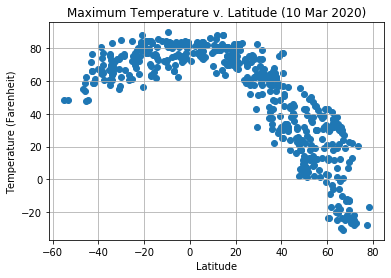

In [7]:
fig = plot_metric_against_latitude(1, city_weather, "Max_Temp", "Temperature (Farenheit)", "Maximum Temperature")

In [8]:
plt.close(fig)

#### Latitude vs. Humidity Plot

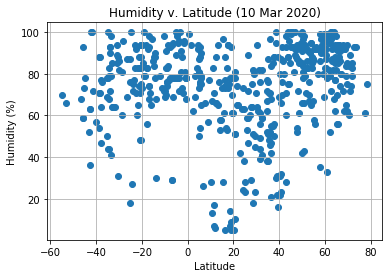

In [9]:
fig = plot_metric_against_latitude(2, city_weather, "Humidity", "Humidity (%)", "Humidity")

In [10]:
plt.close(fig)

#### Latitude vs. Cloudiness Plot

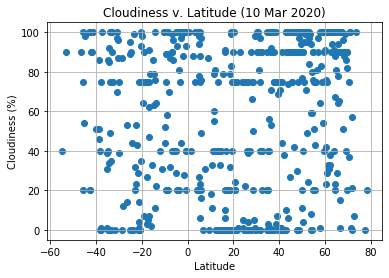

In [11]:
fig = plot_metric_against_latitude(3, city_weather, "Cloudiness", "Cloudiness (%)", "Cloudiness")

In [12]:
plt.close(fig)

#### Latitude vs. Wind Speed Plot

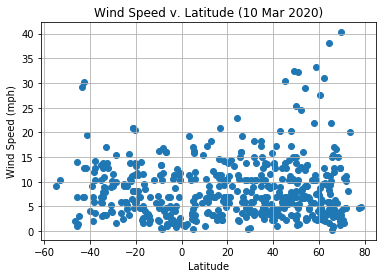

In [13]:
fig = plot_metric_against_latitude(4, city_weather, "Wind_Speed", "Wind Speed (mph)", "Wind Speed")

In [14]:
plt.close(fig)

## Linear Regression

In [46]:
# OPTIONAL: Create a function to create Linear Regression plots
# Add the linear regression equation and line to plot
def plot_metric_with_linear_regression(figure_number, x_series, y_series, x_label, y_label, title):
    fig = plt.figure(figure_number, figsize=[12, 9])
    plt.scatter(x_series,y_series)
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_series, y_series)
    regress_values = x_series * slope + intercept
    plt.plot(x_series,regress_values,"r-")
    annotate_x = x_series.mean()
    annotate_y = annotate_x * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.annotate(line_eq,(annotate_x,annotate_y),color="red",fontsize=20,fontweight="bold")
    plt.annotate(f"r={rvalue:.2f}",(x_series.min(),y_series.min()),color="red",fontsize=20,fontweight="bold")
    plt.grid()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.savefig(f"output_data/Figure{figure_number}.png")
    plt.show()
    return fig

In [47]:
# Create Northern and Southern Hemisphere DataFrames
city_weather_north = city_weather[city_weather["Lat"] >= 0]
city_weather_south = city_weather[city_weather["Lat"] < 0].copy()
# Flip the negative sign of the southern latitudes, to indicate distance away from the equator
city_weather_south["Lat"] *= -1

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

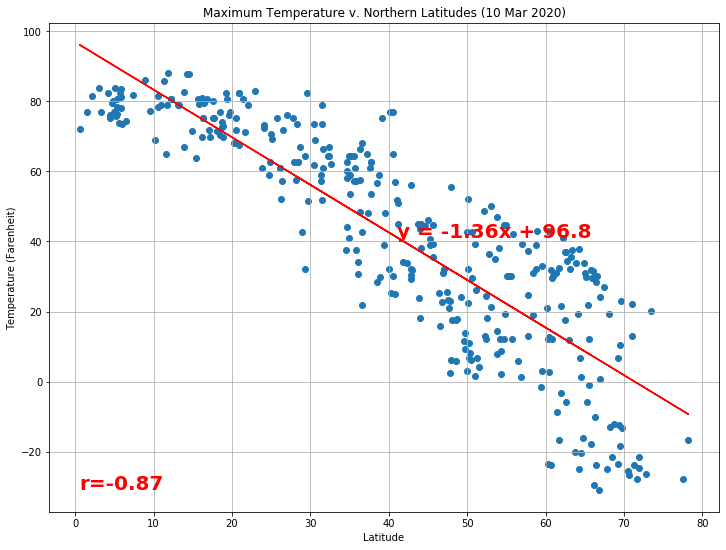

In [48]:
fig = plot_metric_with_linear_regression(5, city_weather_north["Lat"], city_weather_north["Max_Temp"], 
                                         "Latitude", "Temperature (Farenheit)", 
                                         f"Maximum Temperature v. Northern Latitudes ({weather_date})")

In [49]:
plt.close(fig)

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

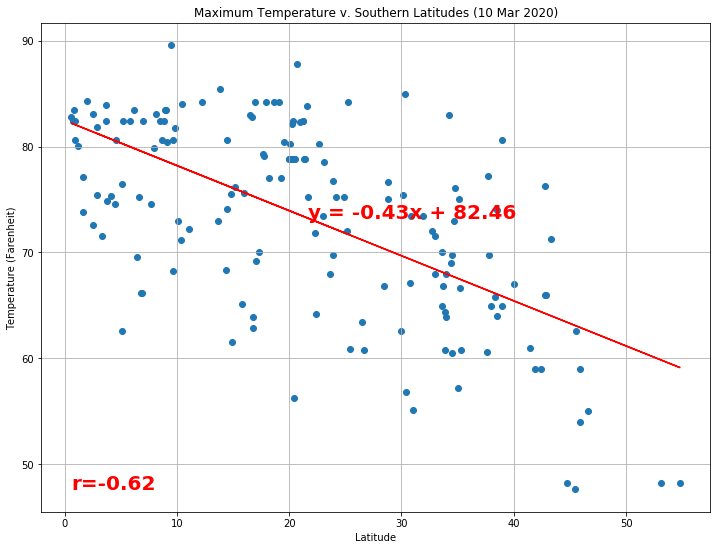

In [50]:
fig = plot_metric_with_linear_regression(6, city_weather_south["Lat"], city_weather_south["Max_Temp"], 
                                         "Latitude", "Temperature (Farenheit)", 
                                         f"Maximum Temperature v. Southern Latitudes ({weather_date})")

In [ ]:
plt.close(fig)

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

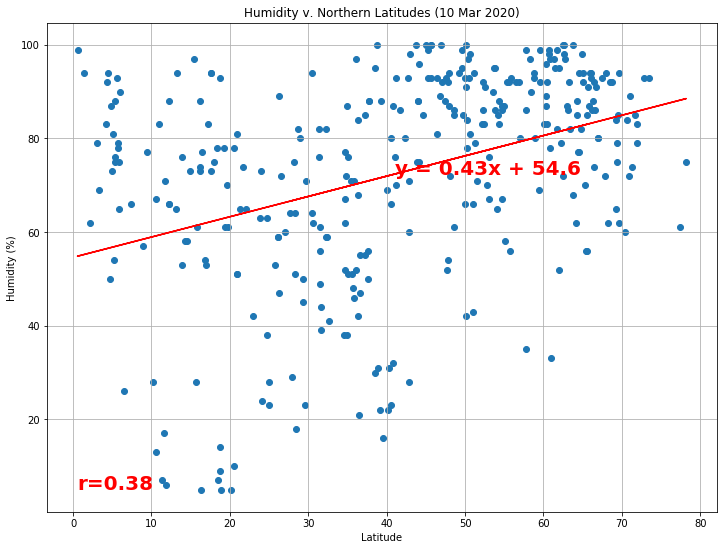

In [51]:
fig = plot_metric_with_linear_regression(7, city_weather_north["Lat"], city_weather_north["Humidity"], 
                                         "Latitude", "Humidity (%)", 
                                         f"Humidity v. Northern Latitudes ({weather_date})")

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

In [ ]:
plt.close(fig)

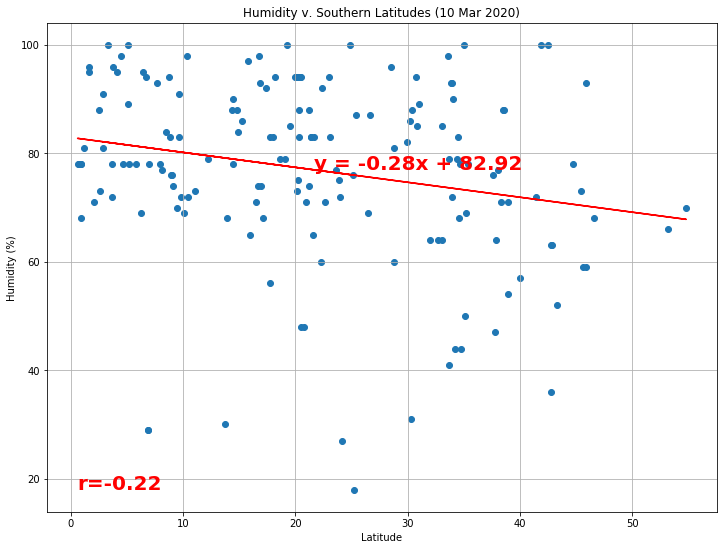

In [57]:
fig = plot_metric_with_linear_regression(8, city_weather_south["Lat"], city_weather_south["Humidity"], 
                                         "Latitude", "Humidity (%)", 
                                         f"Humidity v. Southern Latitudes ({weather_date})")

In [53]:
plt.close(fig)

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

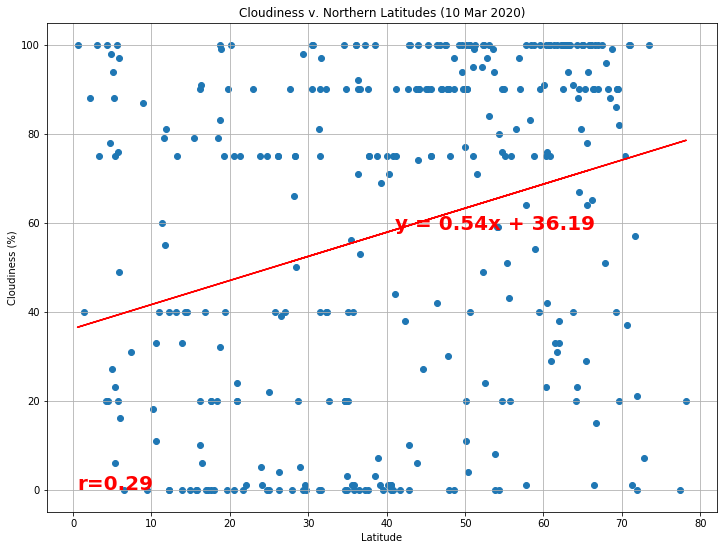

In [54]:
fig = plot_metric_with_linear_regression(9, city_weather_north["Lat"], city_weather_north["Cloudiness"], 
                                         "Latitude", "Cloudiness (%)", 
                                         f"Cloudiness v. Northern Latitudes ({weather_date})")

In [55]:
plt.close(fig)

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

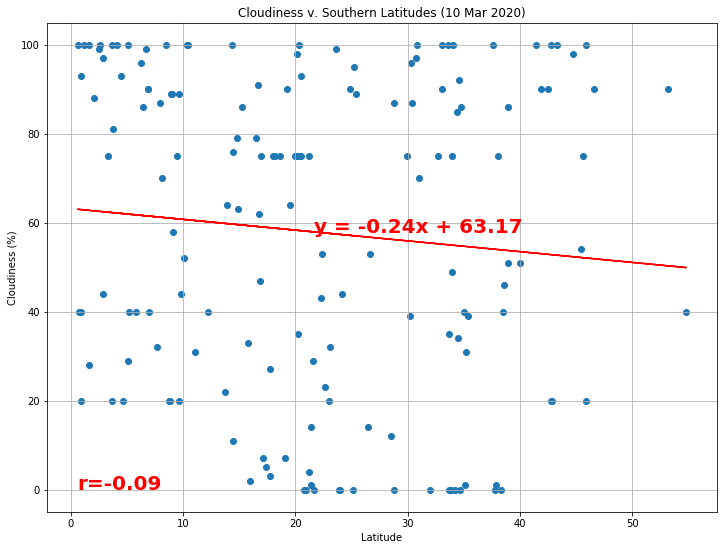

In [58]:
fig = plot_metric_with_linear_regression(10, city_weather_south["Lat"], city_weather_south["Cloudiness"], 
                                         "Latitude", "Cloudiness (%)", 
                                         f"Cloudiness v. Southern Latitudes ({weather_date})")

In [59]:
plt.close(fig)

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

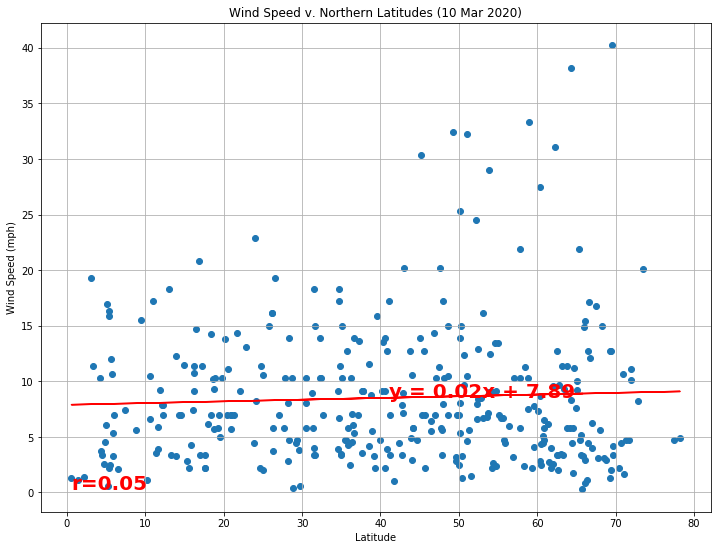

In [62]:
fig = plot_metric_with_linear_regression(11, city_weather_north["Lat"], city_weather_north["Wind_Speed"], 
                                         "Latitude", "Wind Speed (mph)", 
                                         f"Wind Speed v. Northern Latitudes ({weather_date})")

In [63]:
plt.close(fig)

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

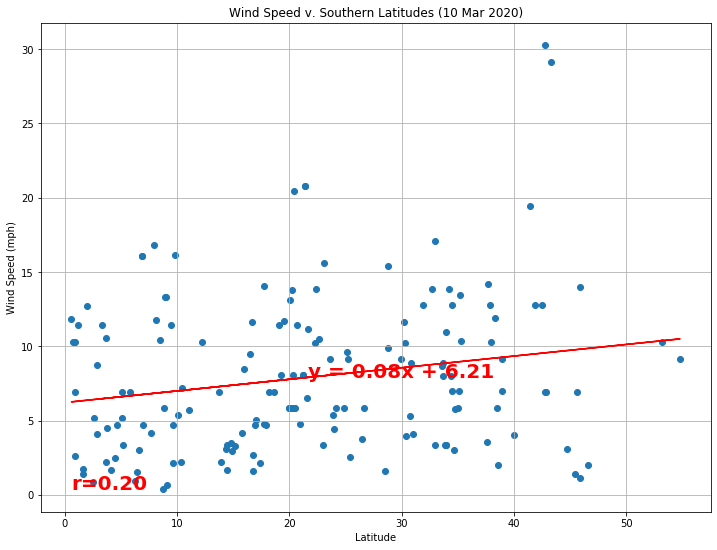

In [64]:
fig = plot_metric_with_linear_regression(12, city_weather_south["Lat"], city_weather_south["Wind_Speed"], 
                                         "Latitude", "Wind Speed (mph)", 
                                         f"Wind Speed v. Southern Latitudes ({weather_date})")

In [ ]:
plt.close(fig)